In [1]:
! pip install pymc

# Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
import pandas as pd
from scipy.stats import boxcox
import pymc as pm
import arviz as az
from scipy.optimize import minimize
from scipy.stats import gamma

from scipy.special import inv_boxcox
import statsmodels.api as sm
pd.set_option('display.max_columns', 200)

# Loading Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/AirQo African Air Quality Prediction Challenge/"

In [5]:
data = pd.read_csv(path + 'Train.csv')
test = pd.read_csv(path + 'Test.csv')

In [6]:
def plot_missing(data_frame):
  missing_data = data_frame.isnull().sum()
  total_cells = data_frame.shape[0]
  missing_percentage = (missing_data / total_cells) * 100

  missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})

  missing_info = missing_info[missing_info['Percentage'] >= 0].sort_values(by='Percentage', ascending=False)

  plt.figure(figsize=(12, 6))
  plt.barh(missing_info.index, missing_info['Percentage'])
  plt.xlabel('Pourcentage de valeurs manquantes')
  plt.ylabel('Colonnes')
  plt.title('Proportions de valeurs manquantes dans le dataframe train')
  plt.gca().invert_yaxis()
  plt.show()
  return missing_info

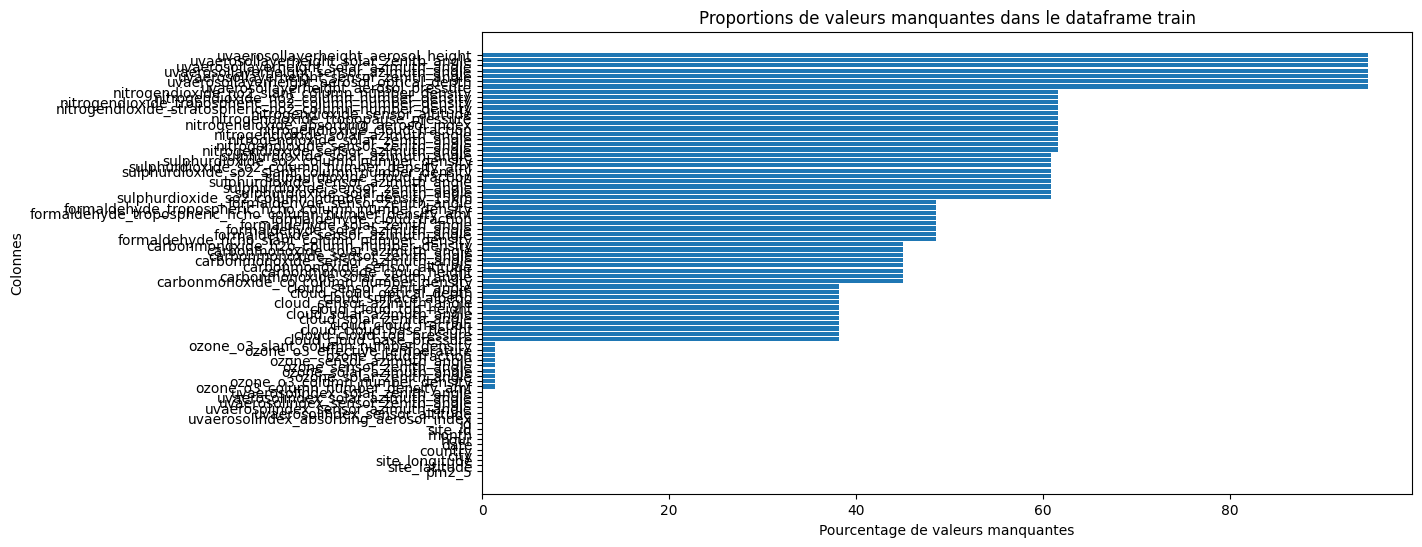

In [7]:
miss_var = plot_missing(data)

In [8]:
miss_var = miss_var.drop_duplicates(subset='Missing Values')
use_var = list(miss_var.index)
use_var.pop()

'id'

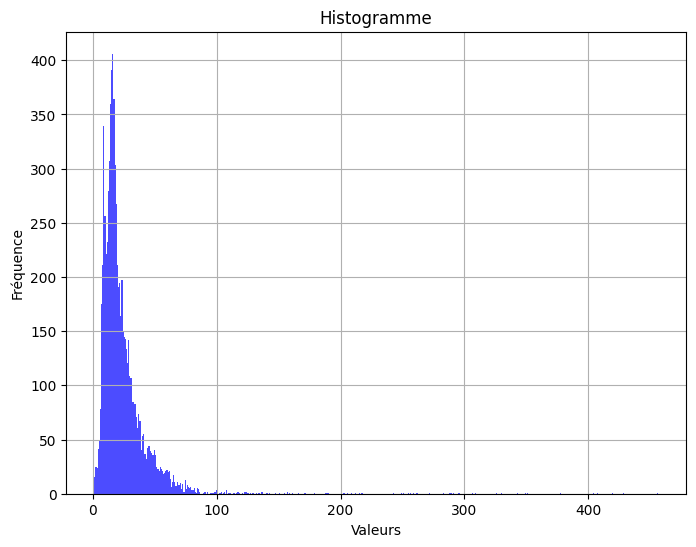

In [39]:
plt.figure(figsize=(8, 6))
data['pm2_5'].hist(bins=500, color='blue', alpha=0.7)
plt.title('Histogramme')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

In [40]:
def feature_analysis(df) :
  df['date'] = pd.to_datetime(df['date'])
  df['year'] = (df['date'].dt.year  == 2024).astype(int)
  df['month'] = df['date'].dt.month

  df['is_weekend'] = (df['date'].dt.dayofweek > 5).astype(int)

  reference_longitude = 36.914272
  reference_latitude = -1.307282
  df['distance_to_reference'] = ((df['site_longitude'] - reference_longitude)**2 + (df['site_latitude'] - reference_latitude)**2)**0.5

  for variable in use_var:
    df[variable + '_isNull'] = (df[variable].isnull()).astype(int)

  df = df.sort_values(by='date')
  df = df.ffill().bfill().copy()

  use_var_ = list(df.columns)
  use_var_.remove('hour')
  use_var_.remove('date')
  use_var_.remove('month')
  use_var_ = sorted(use_var_)

  return df[use_var_].reset_index(drop=True)

In [41]:
feat_data = feature_analysis(data.copy()).select_dtypes(include=['number'])
feat_data.head(3)

,carbonmonoxide_cloud_height,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_h2o_column_number_density_isNull,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,cloud_cloud_base_height,cloud_cloud_base_pressure,cloud_cloud_fraction,cloud_cloud_optical_depth,cloud_cloud_top_height,cloud_cloud_top_pressure,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_sensor_zenith_angle_isNull,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,cloud_surface_albedo,distance_to_reference,formaldehyde_cloud_fraction,formaldehyde_hcho_slant_column_number_density,formaldehyde_sensor_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_zenith_angle_isNull,formaldehyde_solar_azimuth_angle,formaldehyde_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,is_weekend,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_no2_slant_column_number_density_isNull,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_tropospheric_no2_column_number_density,ozone_cloud_fraction,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_effective_temperature,ozone_o3_slant_column_number_density,ozone_o3_slant_column_number_density_isNull,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,pm2_5,site_latitude,site_longitude,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_15km,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_azimuth_angle_isNull,sulphurdioxide_solar_zenith_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,uvaerosolindex_solar_zenith_angle_isNull,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_height_isNull,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,year
0,2626.052002,0.035434,1377.543213,0,829662.750,72.585709,23.317047,-142.806976,29.826069,7946.232683,38377.548135,0.00567,2.117922,8946.232716,33758.739389,72.871375,50.469045,1,-149.969932,27.102595,0.251904,4.692595,0.125426,0.000117,75.473899,23.387697,0,-142.840866,29.807096,0.000177,0.983945,1,-0.635923,0.063107,0.000081,0.000122,0,829681.073656,75.473899,23.387697,-142.840866,29.807096,0.000032,8613.731155,0.000049,0.127222,0.118602,2.266515,229.977261,0.273651,0,75.473899,23.387697,-142.840866,29.807096,14.1603,0.363000,32.52900,0.125426,75.473899,23.387697,-0.000250,-0.000066,0.560163,-0.000139,-142.840866,0,29.807096,-0.635924,829681.073656,75.473899,23.387697,-142.840866,29.807096,0,1162.714752,1,1.578868,88394.564774,75.529068,22.704029,-142.796692,29.907488,0
1,1627.726807,0.031180,1435.708740,0,829669.125,72.573074,22.743303,-142.666702,29.852840,7946.232683,38377.548135,0.00567,2.117922,8946.232716,33758.739389,72.871375,50.469045,1,-149.969932,27.102595,0.251904,4.574513,0.020481,0.000051,75.549082,22.521311,0,-142.647539,29.857936,0.000110,0.981518,1,-0.431675,0.030820,0.000050,0.000092,0,829688.6

In [42]:
target = 'pm2_5'
feat_data.shape

(8071, 84)

In [43]:
test_use = feature_analysis(test.copy())
test_x = test_use.select_dtypes(include=['number'])
col_use = test_x.columns

In [78]:
scaler = StandardScaler()
scaler.fit(feat_data[col_use])
feat_data_scal = scaler.transform(feat_data[col_use])
feat_data_scal = pd.concat([pd.DataFrame(feat_data_scal, columns=col_use),feat_data.pm2_5], axis=1)
test_x_scal = pd.DataFrame(scaler.transform(test_x[col_use]), columns=col_use)

In [79]:
feat_data_scal.shape, test_x_scal.shape

((8071, 84), (2783, 83))

# Diviser pour mieux ... dattebayo

In [59]:
feat_data_scal[target].quantile([0.25, 0.5, 0.75])

0.25    13.2706
0.50    18.3754
0.75    28.8384
Name: pm2_5, dtype: float64

In [60]:
quartiles = feat_data_scal[target].quantile([0.25, 0.5, 0.75])
def categorize(value):
    if value <= quartiles[0.25]:
        return 0
    elif value <= quartiles[0.5]:
        return 1
    elif value <= quartiles[0.75]:
        return 2
    else:
        return 3

feat_data_scal['target_cat'] = feat_data_scal[target].apply(categorize)

In [61]:
X = feat_data_scal.drop(columns=[target, 'target_cat'])
y_cat = feat_data_scal['target_cat']
y_reg = feat_data_scal[target]

classifier = RandomForestClassifier()
classifier.fit(X, y_cat)

test_probs = classifier.predict_proba(test_x_scal)

In [62]:
regressors = {}
for i in range(4):
    subset = feat_data_scal[feat_data_scal['target_cat'] == i]
    X_subset = subset.drop(columns=[target, 'target_cat'])
    y_subset = subset[target]

    regressor = RandomForestRegressor()
    regressor.fit(X_subset, y_subset)

    regressors[i] = regressor

In [63]:
predictions = np.zeros(test_x_scal.shape[0])
for i in range(4):
    preds = regressors[i].predict(test_x_scal)
    predictions += preds * test_probs[:, i]

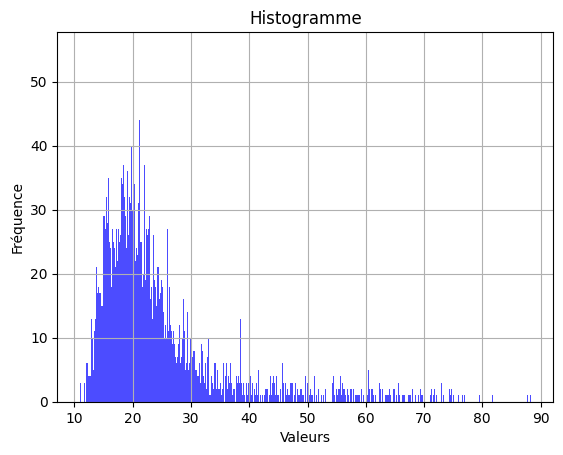

In [64]:
pd.DataFrame({'ID': test.id, 'pm2_5': predictions})['pm2_5'].hist(bins=500, color='blue', alpha=0.7)
plt.title('Histogramme')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

# Reg GLM

In [79]:
X = feat_data_scal.drop(columns=[target])
y = feat_data_scal[target]

X = sm.add_constant(X)

model = sm.GLM(y, X, family=sm.families.Gamma(sm.families.links.log()))
results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [76]:
predictions.shape

(8071, 2783)

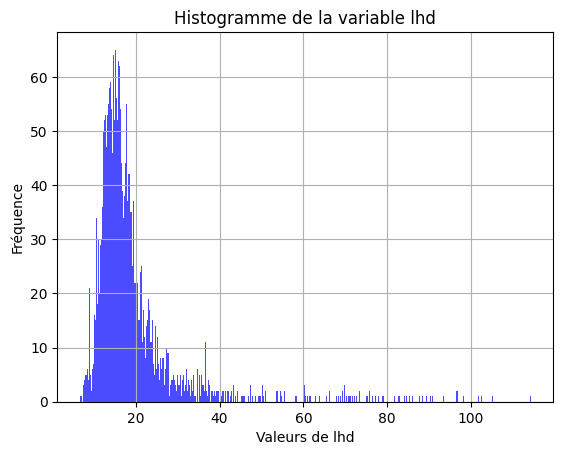

In [80]:
predictions = results.predict(sm.add_constant(test_x_scal))
pd.DataFrame({'ID': test.id, 'pm2_5': predictions})['pm2_5'].hist(bins=500, color='blue', alpha=0.7)
plt.title('Histogramme')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

# Transformation Box Cox

In [85]:
y_transformed, lam = boxcox(y + 1)

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(feat_data_scal.drop(columns=[target]), y_transformed)

pred_test_transformed = model.predict(test_x_scal)
pred_test = inv_boxcox(pred_test_transformed, lam) - 1

# MC MC Bayesien

In [87]:
X = feat_data_scal.drop(columns=[target])
y = feat_data_scal[target]

X = sm.add_constant(X)

with pm.Model() as model:
    prior_alpha = 2
    prior_beta = 1 / 50

    pm2_5_prior = pm.Gamma('pm2_5_prior', alpha=prior_alpha, beta=prior_beta)

    X_shared = pm.MutableData('X', X)

    beta = pm.Normal('beta', mu=0, sigma=100, shape=X_shared.shape[1])

    intercept = pm.Normal('intercept', mu=0, sigma=100)

    mu = intercept + pm.math.dot(X_shared, beta)

    nu = pm.Exponential('nu', 20)
    y_obs = pm.ChiSquared('y_obs', nu=nu, mu=mu, observed=y)

    trace = pm.sample(10000, tune=100000, return_inferencedata=True)

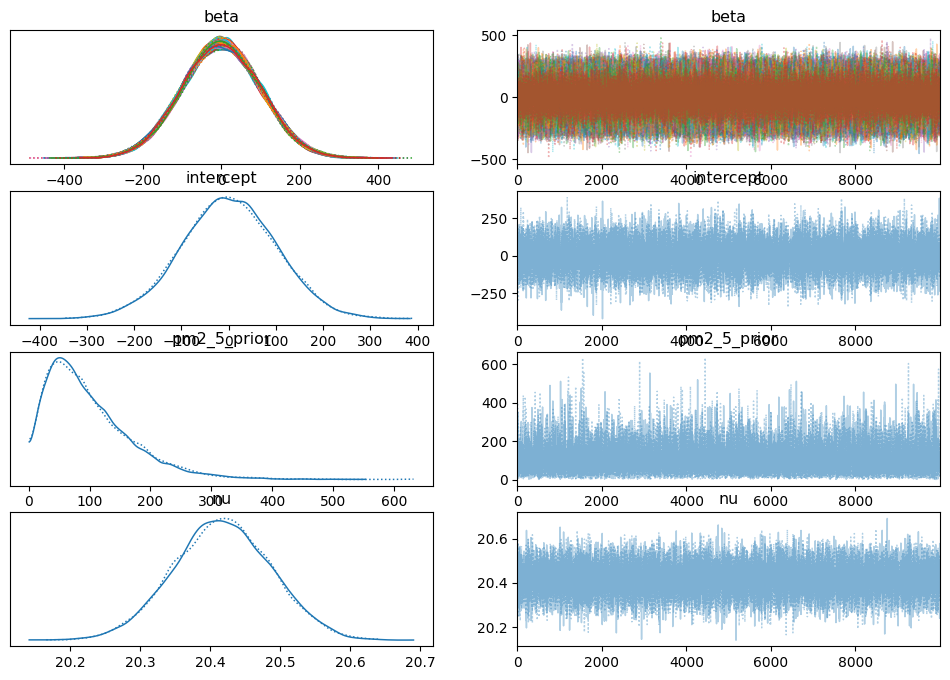

In [88]:
az.plot_trace(trace)
plt.show()

In [89]:
beta_samples = trace.posterior['beta'].values
intercept_samples = trace.posterior['intercept'].values

In [90]:
predictions = []
for i in range(len(beta_samples)):
    beta_sample = beta_samples[i]
    intercept_sample = intercept_samples[i]

    y_pred_sample = np.dot(sm.add_constant(test_x_scal).values, beta_sample.T) + intercept_sample
    predictions.append(y_pred_sample)


In [84]:
np.mean(predictions, axis=0).mean(axis=1).shape

(2783,)

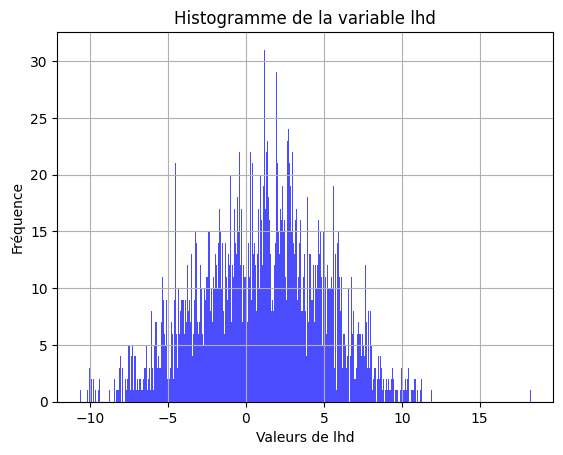

In [91]:
pd.DataFrame({'ID': test.id, 'pm2_5': np.mean(predictions, axis=0).mean(axis=1)})['pm2_5'].hist(bins=500, color='blue', alpha=0.7)
plt.title('Histogramme de la variable lhd')
plt.xlabel('Valeurs de lhd')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

## Submission

In [65]:
submission = pd.DataFrame({'ID': test.id, 'pm2_5': predictions})
submission.to_csv('submission_norm_02.csv', index=False)